In [68]:
pwd

'/Users/edwardterrell/Desktop/covid_machinations'

In [69]:
# this block is used for copying/moving files
import os
import shutil
import time
#shutil.copyfile('src', 'dst')
#shutil.move

# we want to ensure we are in the correct conda environment
import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/envs/scrape/bin/python'

In [70]:
# This is a custom python module with dictionaries of states and countries; 
# it also contains three functions repair_dict, reverse_dict, and custom_list
import state_country_dicts as scd

In [71]:
# provides ability to reload modules (wihtout leaving jupyter) if changes are made
#import importlib
#importlib.reload(scd)

In [72]:
import numpy as np
import pandas as pd

In [73]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup as bs
# import regular expressions
import re 

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

### Cornavirus section

In [74]:
# get current date for use in creating filenames with embedded 'day'. 
# convert datetime object to string
import datetime as dt
today  = dt.date.today()
day = today.strftime('%Y-%m-%d')
day

'2021-04-15'

In [75]:
print ('If using Binder enter a timezone difference from UTC')
timezone = input(' Enter a number between 12 and -12:')
print(timezone)
if timezone:
    timezone = int(timezone)
    v = scd.tz_dict[timezone]
    t = pd.Timestamp.today(v)
    print (t)
    day = t.date().strftime('%Y-%m-%d')
day

If using Binder enter a timezone difference from UTC


 Enter a number between 12 and -12: 


'2021-04-15'

### Moves all files from covid_data_update to covid_data 

In [76]:
# House keeping covid_data_update folder
# prepare move of all files from covid_data_update to covid_data 
# so that we are left with an empty covid_date_update folder
file_names = []
source_dir = 'covid_data_update'
target_dir = 'covid_data'
print("covid_data_update directory contents:") 

file_names = os.listdir(source_dir)
print (file_names)
if file_names == []:
    print ('Directory is empty so no files available to move')

covid_data_update directory contents:
['us_2021-04-15.png', 'boulder-2021-04-15.csv', 'outbreaks-DATE-2021-04-15.csv', 'world_rolling_avg_2021-04-15.png', 'this_month_outbreaks-piechart-2021-04-15.png', 'us_rolling_avg_2021-04-15.png', 'outbreaks-TYPE-2021-04-15.csv', 'outbreaks-COUNTY-2021-04-15.csv', 'outbreaks-TOTAL-2021-04-15.csv', 'outbreaks-per-month-2021-04-15.png', 'world_2021-04-15.png', 'us_AZ_last_90_days_2021-04-15.png', 'us_AZ_last_60_days_2021-04-15.png', 'outbreaks-piechart-2021-04-15.png', 'world_FR_last_60_days_2021-04-15.png', 'world_FR_last_90_days_2021-04-15.png']


In [77]:
# The below cell will move and archive all files in covid_data_update to covid_data

In [78]:
%%capture
# Move contents of source ('covid_data_update')to target ('covid_data')
for file_name in file_names:
    shutil.move(os.path.join(source_dir, file_name), target_dir)

In [79]:
def clean_up (number_str):
    '''This is a clean up routine so that only numeric characters remain'''
    number_str = number_str.replace(',', '').rstrip(']').lstrip("'")
    return int(number_str)

### Custom state dictionaries

In [80]:
# creates a custom state dict
s_string = input('Enter state codes seperated by a space:') or 'ca tx fl az co ny il'
print()

slist = scd.custom_list (s_string)
state_dict = {key: value for key, value in scd.all_states.items() if value in slist}
state_dict

Enter state codes seperated by a space: az co


{'arizona': 'AZ', 'colorado': 'CO'}

### State Scraping section

In [81]:
# The start dates for U.S.states and for countries are different so must be accounted for
st_start = pd.Timestamp('2020/3/13')
c_start = pd.Timestamp('2020/2/16')

# set end time to yesterday

#day == pd.Timestamp.today().strftime('%Y-%m-%d')
end = pd.Timestamp.today() - pd.Timedelta(days=1)
print(f'end changed to yesterday: {end}')
#else:
#   end = pd.Timestamp.today()
#    print(f'end changed to {end}')
    
# set the index to the appropriate date range for states and countries
st_index = pd.date_range(st_start, end)
c_index = pd.date_range(c_start, end)
len(st_index)
len(c_index)

# list comprehension to extract just the state initials from the dict
st_list = list(state_dict.values())

# create an empty pandas df with column headers from state_dict
state = pd.DataFrame(columns = st_list,index=st_index)
state.sort_index(ascending = False).head()
state.shape

end changed to yesterday: 2021-04-14 10:07:42.692827


398

424

,AZ,CO
2021-04-14,NaN,NaN
2021-04-13,NaN,NaN
2021-04-12,NaN,NaN
2021-04-11,NaN,NaN
2021-04-10,NaN,NaN


(398, 2)

In [82]:
state_url='https://www.worldometers.info/coronavirus/usa/'
# Here the keys are the state names and the values are the 2-letter abbreviation
for key, value in state_dict.items():
    url = state_url+key

    # scrape web page for state info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break
    

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    #state_previous_cases is a list of daily new coronavirus cases
    state_previous_cases = mo.group().split(',')[1:]
    len(state_previous_cases)
    
    # ensure match between length of the empty df and the new list
    if len(st_index)!= len(state_previous_cases):
        print (len(st_index))
        print (len(state_previous_cases))
        state_previous_cases = state_previous_cases[:-1]
        print (len(state_previous_cases))
    
    # merge states into the existing df and apply the function clean_up to convert strings to ints
    # state[value] where value is the 2-letter abreviation
    state[value] = state_previous_cases
    state[value] = state[value].apply(clean_up)
    
    time.sleep(2)
state.sort_index(ascending = False).head()   

398

398

,AZ,CO
2021-04-14,419,2324
2021-04-13,610,1904
2021-04-12,675,912
2021-04-11,540,1235
2021-04-10,819,1455


In [83]:
def list2string(l): 
    ''' This creates a a short string of state/country names 
    used during file save
    '''
    str1 = "_" 
    # return string  
    return (str1.join(l))

States available: ['AZ', 'CO']



Choose state for rolling averge: 


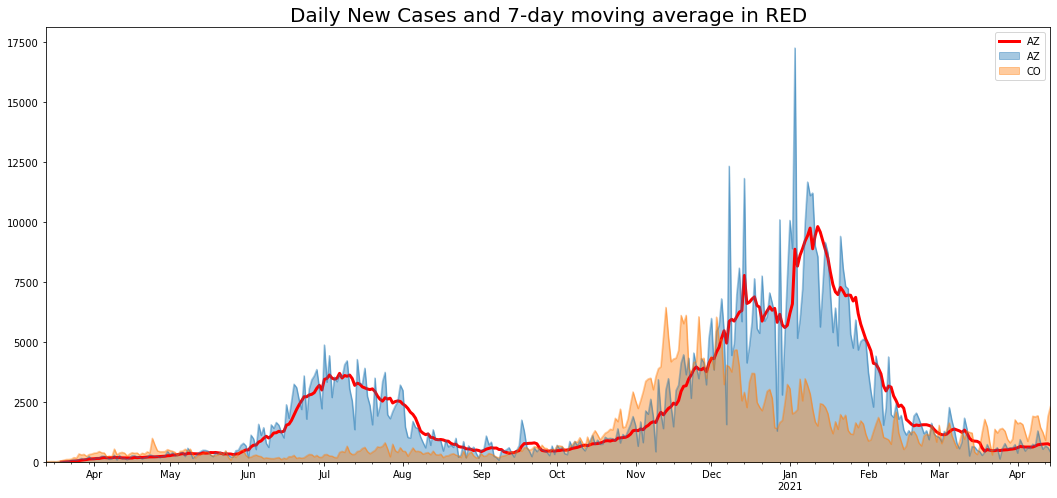

In [84]:
# Allows user to select state for rolling average 
s_available = list(state.columns)
print(f'States available: {s_available}')
print()

snames = (list2string(s_available))

select_state = input('Choose state for rolling averge:')or s_available[0]
select_state = select_state.upper()

if select_state not in s_available:
    select_state = s_available[0]

# Plot Daily New Cases and 7-day moving averge
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data = state.loc[:,[select_state]].rolling(window=7).mean()

roll_data.plot(ax=ax, linewidth=3, color='r')
state.plot(kind='area',alpha=.4,ax=ax,stacked=False);
plt.title('Daily New Cases and 7-day moving average in RED', fontsize=20) 

#ax.set_title('Daily New Cases and 7-day moving average in RED', fontsize=20) 
plt.savefig(f'./covid_data_update/us_{day}.png');

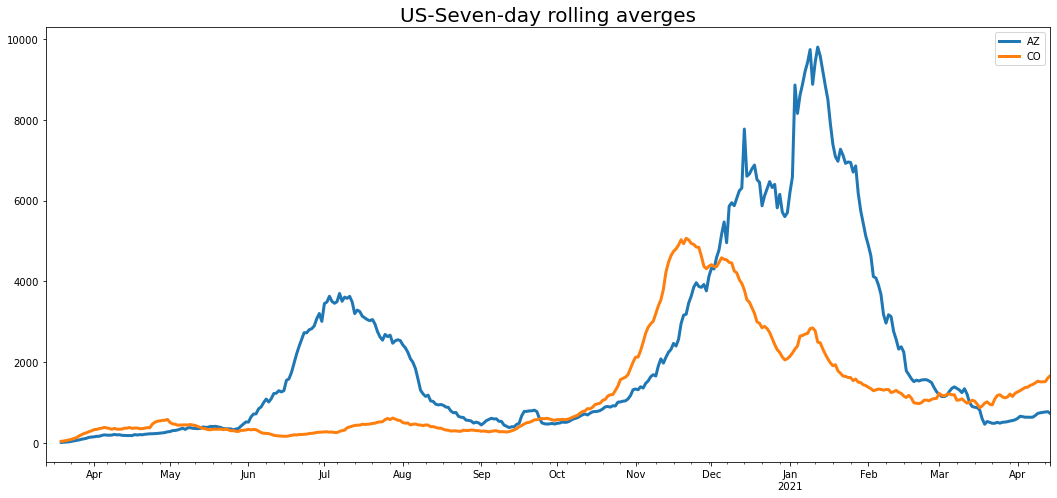

In [85]:
# Plot 7-day moving averge
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = state.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('US-Seven-day rolling averges',fontsize=20)
plt.savefig(f'./covid_data_update/us_rolling_avg_{day}.png');

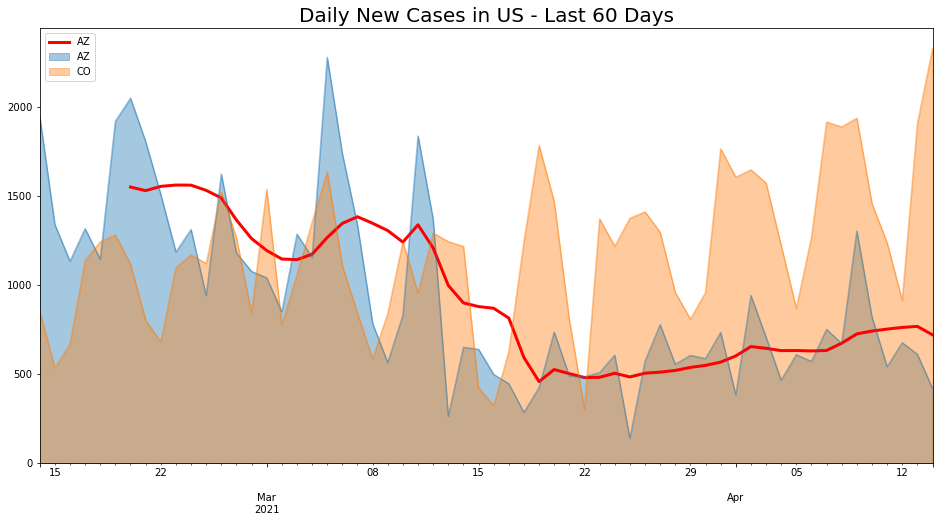

In [86]:
# Plot Last 60 Days
plt.close('all')
# Select last 60 days only
state_last60 = state.tail(60)

roll_data = state_last60.loc[:,[select_state]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
state_last60.plot(kind='area',alpha=.4,ax=ax,stacked=False);

plt.title('Daily New Cases in US - Last 60 Days',fontsize=20)
plt.savefig(f'./covid_data_update/us_{snames}_last_60_days_{day}.png');

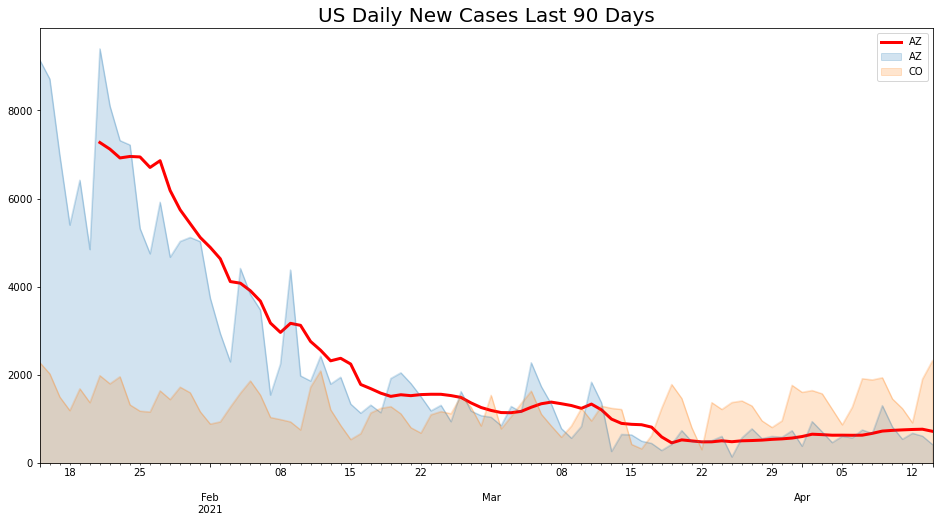

In [87]:
# Plot last 90 days
plt.close('all')
# Select last 90 days only
state_last90 = state.tail(90)

roll_data = state_last90.loc[:,[select_state]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
state_last90.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('US Daily New Cases Last 90 Days',fontsize=20)
plt.savefig(f'./covid_data_update/us_{snames}_last_90_days_{day}.png');

In [88]:
# Daily New Cases in tabular format
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)
state.sort_index(ascending = False)

,AZ,CO
2021-04-14,419,2324
2021-04-13,610,1904
2021-04-12,675,912
2021-04-11,540,1235
2021-04-10,819,1455
2021-04-09,1302,1935
2021-04-08,670,1886
2021-04-07,750,1913
2021-04-06,570,1266
2021-04-05,608,867


### Custom country dictionaries

In [89]:
# creates a custom country dict
c_string = input('Enter country codes seperated by a space:') or 'fr it es uk de'
clist = scd.custom_list (c_string)

country_dict = {key: value for key, value in scd.all_countries.items() if value in clist}
print(country_dict)

print()

Enter country codes seperated by a space: 


{'germany': 'DE', 'spain': 'ES', 'france': 'FR', 'uk': 'UK', 'italy': 'IT'}



### Scraping section

In [90]:
c_list = list(country_dict.values())
c_list

# create an empty pandas df with column headers from country_dict, using the starting dates for the country as index
country = pd.DataFrame(columns = c_list,index=c_index)
country.sort_index(ascending = False).head()

base_url='https://www.worldometers.info/coronavirus/country/'
# Here the keys are the country names and the values are the 2-letter abbreviation
for key, value in country_dict.items():
    url = base_url+key
    print(url)

    # scrape web page for country info and assign to soup
    response = requests.get(url)
    #response.status_code
    page = response.text
    #print(response.text[:400])
    soup = bs(page)
    
    # Find block of text/data near 'graph-cases-daily' 
    re_graph = re.compile('graph-cases')
    dat = soup.find(text=re_graph)
   
    try:
        data = soup.find(text=re_graph).parent
    except:
        print(f'Unable to find {url}')
        print()
        break

    # Regex to pull out data chunk out of the larger soup like data
    myregex = re.compile (r'data:.*\]')
    mo = myregex.search(str(data))

    #mo.group() is a string so easy to get rid of the first entry
    country_previous_cases = mo.group().split(',')[1:]
    #print(country_previous_cases)
    previous_cases = ["0" if i == 'null' else i for i in country_previous_cases]
    
    len(previous_cases)

    # merge countries into the existing df and apply the function clean_up to convert strings to ints
    country[value] = previous_cases
    country[value] = country[value].apply(clean_up)
    
    time.sleep(2)
country.clip(lower=0,inplace=True) #large negative number removed for better graphic clarity
country.sort_index(ascending = False).head()

['DE', 'ES', 'FR', 'UK', 'IT']

,DE,ES,FR,UK,IT
2021-04-14,NaN,NaN,NaN,NaN,NaN
2021-04-13,NaN,NaN,NaN,NaN,NaN
2021-04-12,NaN,NaN,NaN,NaN,NaN
2021-04-11,NaN,NaN,NaN,NaN,NaN
2021-04-10,NaN,NaN,NaN,NaN,NaN


https://www.worldometers.info/coronavirus/country/germany


424

https://www.worldometers.info/coronavirus/country/spain


424

https://www.worldometers.info/coronavirus/country/france


424

https://www.worldometers.info/coronavirus/country/uk


424

https://www.worldometers.info/coronavirus/country/italy


424

,DE,ES,FR,UK,IT
2021-04-14,32546,10474,43505,2490,16168
2021-04-13,10772,6292,39113,2472,13439
2021-04-12,11523,7446,8536,3567,9781
2021-04-11,16738,9107,34895,1730,15737
2021-04-10,18693,6191,43284,2589,17558


Countries available: ['DE', 'ES', 'FR', 'UK', 'IT']



Choose country for rolling averge: 


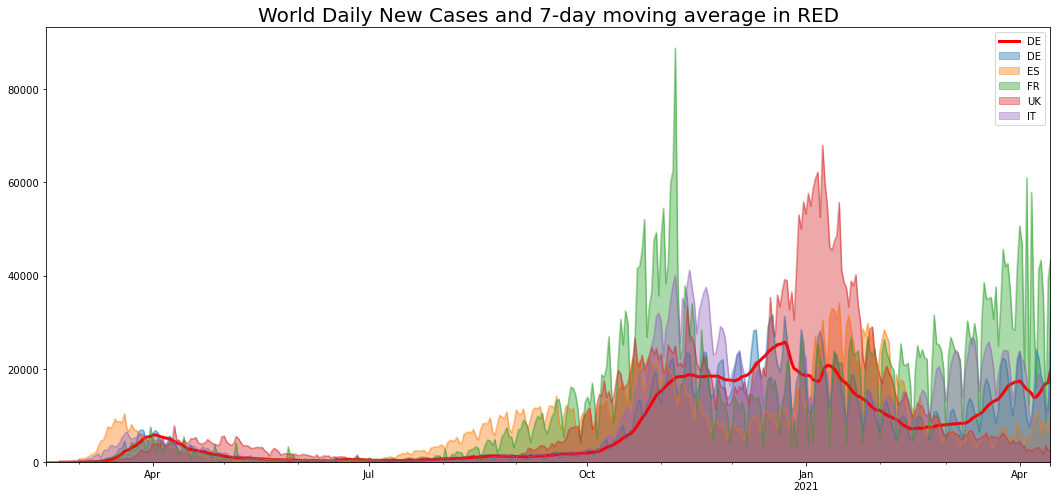

In [91]:
# Allows user to select the country for the rolling average
c_available = list(country.columns)
print(f'Countries available: {c_available}')
print()

snames = (list2string(c_available))

select_country = input('Choose country for rolling averge:') or c_available[0]
select_country = select_country.upper()

if select_country not in c_available:
    select_country = c_available[0]

# Plot Daily New Cases and 7-day moving averge
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data = country.loc[:,[select_country]].rolling(window=7).mean()


roll_data.plot(ax=ax, linewidth=3, color='r')
country.plot(kind='area',alpha=.4,ax=ax,stacked=False)
plt.title('World Daily New Cases and 7-day moving average in RED',fontsize=20);
# insert {snames} if desired 
plt.savefig(f'./covid_data_update/world_{day}.png');

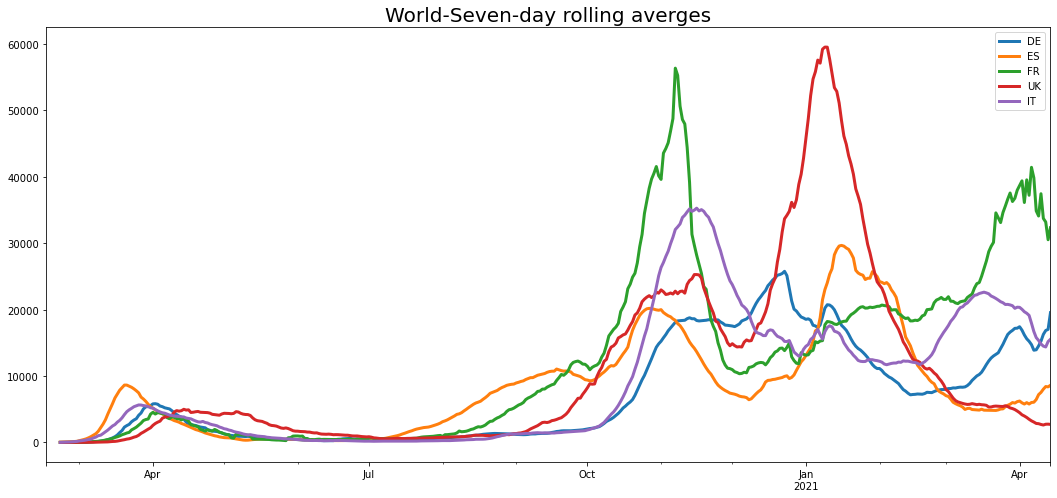

In [92]:
# Plot 7-day moving averge
plt.close('all')
fig,ax = plt.subplots(1,1,figsize=(18,8))
roll_data_all = country.rolling(window=7).mean()
roll_data_all.plot(ax=ax, linewidth=3);
plt.title('World-Seven-day rolling averges',fontsize=20)
# insert {snames} if desired 
plt.savefig(f'./covid_data_update/world_rolling_avg_{day}.png');

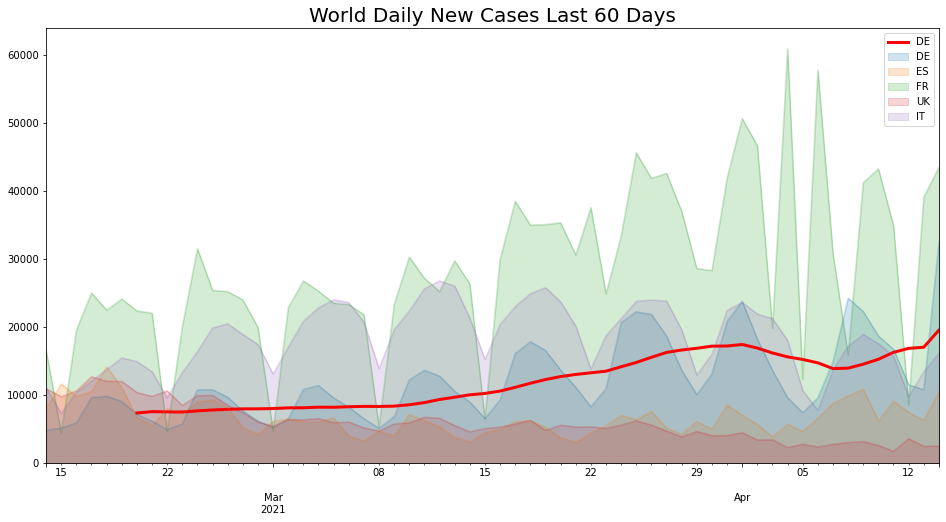

In [93]:
# Plot last 60 days
plt.close('all')
# Select last 60 days only
country_last60 = country.tail(60)

roll_data = country_last60.loc[:,[select_country]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
country_last60.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('World Daily New Cases Last 60 Days',fontsize=20)
plt.savefig(f'./covid_data_update/world_{snames}_last_60_days_{day}.png');


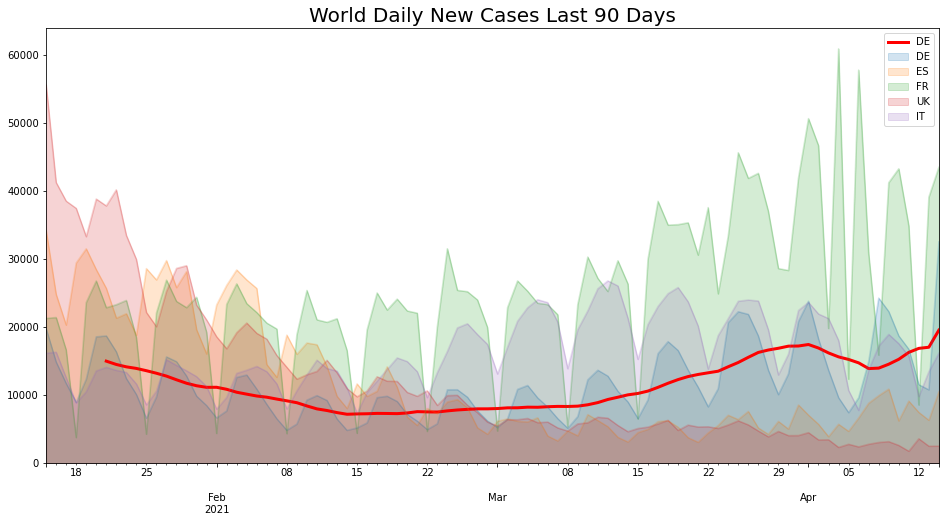

In [94]:
# Plot last 90 days
plt.close('all')
# Select last 90 days only
country_last90 = country.tail(90)

roll_data = country_last90.loc[:,[select_country]].rolling(window=7).mean()
fig,ax = plt.subplots(1,1,figsize=(16,8))
roll_data.plot(ax=ax, linewidth=3, color='r')
country_last90.plot(kind='area',alpha=.2,ax=ax,stacked=False);

plt.title('World Daily New Cases Last 90 Days',fontsize=20)
plt.savefig(f'./covid_data_update/world_{snames}_last_90_days_{day}.png');


In [95]:
# Daily New Cases in tabular format
pd.set_option('display.max_rows', 300)
pd.set_option('display.min_rows', 300)
country.sort_index(ascending = False)

,DE,ES,FR,UK,IT
2021-04-14,32546,10474,43505,2490,16168
2021-04-13,10772,6292,39113,2472,13439
2021-04-12,11523,7446,8536,3567,9781
2021-04-11,16738,9107,34895,1730,15737
2021-04-10,18693,6191,43284,2589,17558
2021-04-09,22281,10875,41243,3145,18922
2021-04-08,24257,9901,15869,3023,17207
2021-04-07,14936,8788,30785,2758,13696
2021-04-06,9600,6623,57799,2374,7745
2021-04-05,7405,4660,12335,2757,10676


### Save merged dataframes to csv

In [96]:
# Merge state and country dfs into one
world = state.merge(country,left_index=True,right_index=True,how='outer')
world = world.fillna(0).astype(int)

In [97]:
# Sorting the table with recent dates on the top
world_table = world.sort_index(ascending = False)

# Save to csv by uncommenting out the next line
# world_table.to_csv(f'./covid_data/world_table{day}.csv')
world_table.head(5)

,AZ,CO,DE,ES,FR,UK,IT
2021-04-14,419,2324,32546,10474,43505,2490,16168
2021-04-13,610,1904,10772,6292,39113,2472,13439
2021-04-12,675,912,11523,7446,8536,3567,9781
2021-04-11,540,1235,16738,9107,34895,1730,15737
2021-04-10,819,1455,18693,6191,43284,2589,17558


In [98]:
# Note that the last week may be only a partial unless this is executed at end of week
df = world.resample('w').sum()
df.sort_index(ascending = False).head(10)

,AZ,CO,DE,ES,FR,UK,IT
2021-04-18,1704,5140,54841,24212,91154,8529,39388
2021-04-11,5259,10557,113910,56145,236210,18376,101541
2021-04-04,4414,9567,109286,41960,276881,26299,136223
2021-03-28,3635,7924,116345,40322,262986,36393,145010
2021-03-21,3510,6662,91165,33805,210941,38074,153239
2021-03-14,6289,7366,70180,34329,167429,39845,155661
2021-03-07,9672,8299,58293,38698,148265,41889,142209
2021-02-28,8815,7689,55778,51160,150787,60932,116024
2021-02-21,10697,6778,52878,69596,140018,77290,87361
2021-02-14,16633,8547,50196,101926,128115,92228,85135
